# Automated CapsnetsS2I train + test

First, import stuff

In [1]:
import model_s2i
import data_loader
import tensorflow as tf

W0822 23:06:40.595973 4694281664 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

## Load word vectors and data

In [3]:
WORD_VEC_SCENARIO = "FastText-300-verbsDatasets-synAntVSP-dia"

word2vec_path = '../../romanian_word_vecs/cleaned-vectors-diacritice.vec'

# No diacritics data
training_data_paths = [
#         '../data-capsnets/scenario0/train.txt',
#         '../data-capsnets/scenario1/train.txt',
#         '../data-capsnets/scenario2/train.txt',
#         '../data-capsnets/scenario3.1/train.txt',
#         '../data-capsnets/scenario3.2/train.txt',
#         '../data-capsnets/scenario3.3/train.txt',
        '../data-capsnets/diacritics/scenario0/train.txt',
        '../data-capsnets/diacritics/scenario1/train.txt',
        '../data-capsnets/diacritics/scenario2/train.txt',
        '../data-capsnets/diacritics/scenario31/train.txt',
        '../data-capsnets/diacritics/scenario32/train.txt',
        '../data-capsnets/diacritics/scenario33/train.txt',
        
    ]
test_data_paths = [
#     '../data-capsnets/scenario0/test.txt',
#     '../data-capsnets/scenario1/test.txt',
#     '../data-capsnets/scenario2/test.txt',
#     '../data-capsnets/scenario3.1/test.txt',
#     '../data-capsnets/scenario3.2/test.txt',
#     '../data-capsnets/scenario3.3/test.txt',
    '../data-capsnets/diacritics/scenario0/test.txt',
    '../data-capsnets/diacritics/scenario1/test.txt',
    '../data-capsnets/diacritics/scenario2/test.txt',
    '../data-capsnets/diacritics/scenario31/test.txt',
    '../data-capsnets/diacritics/scenario32/test.txt',
    '../data-capsnets/diacritics/scenario33/test.txt',
]

scenario_nums = [
#     '0_' + WORD_VEC_SCENARIO,
#     '1_' + WORD_VEC_SCENARIO,
#     '2_' + WORD_VEC_SCENARIO,
#     '31_' + WORD_VEC_SCENARIO,
#     '32_' + WORD_VEC_SCENARIO,
#     '33_' + WORD_VEC_SCENARIO,
#     '0_dia_' + WORD_VEC_SCENARIO,
#     '1_dia_' + WORD_VEC_SCENARIO,
#     '2_dia_' + WORD_VEC_SCENARIO,
#     '31_dia_' + WORD_VEC_SCENARIO,
#     '32_dia_' + WORD_VEC_SCENARIO,
#     '33_dia_' + WORD_VEC_SCENARIO,
    '0-rerouting',
    '1-rerouting',
    '2-rerouting',
    '31-rerouting',
    '32-rerouting',
    '33-rerouting',
]

In [6]:
print('------------------load word2vec begin-------------------')
w2v = data_loader.load_w2v(word2vec_path)
print('------------------load word2vec end---------------------')

------------------load word2vec begin-------------------
loading time took 000.06
------------------load word2vec end---------------------


# Flag setting functions + utils

In [4]:
import csv

def set_flags(data, scenario):
    FLAGS = tf.app.flags.FLAGS

    tf.app.flags.DEFINE_boolean('save_model', False, 'save model to disk')
    tf.app.flags.DEFINE_string('summaries_dir', './logs', 'tensorboard summaries')
    tf.app.flags.DEFINE_string('ckpt_dir', './saved_models/', 'check point dir')
    tf.app.flags.DEFINE_string('scenario_num', scenario, 'Scenario number')
    tf.app.flags.DEFINE_string('errors_dir', './errors/', 'Errors dir')
    tf.app.flags.DEFINE_string('results_dir', './results/', 'Results dir')
    tf.app.flags.DEFINE_string('hyperparams_dir', './hyperparams/', 'Hyperparams dir')
    
    vocab_size, word_emb_size = data['embedding'].shape
    _, max_sentence_length = data['x_tr'].shape
    intents_number = len(data['intents_dict'])
    slots_number = len(data['slots_dict'])
    hidden_size = 64

    tf.app.flags.DEFINE_float('keep_prob', 1, 'embedding dropout keep rate for training')
    tf.app.flags.DEFINE_integer('hidden_size', hidden_size, 'embedding vector size')
    tf.app.flags.DEFINE_integer('batch_size', 32, 'batch size')
    tf.app.flags.DEFINE_integer('num_epochs', 20, 'num of epochs')
    tf.app.flags.DEFINE_integer('vocab_size', vocab_size, 'vocab size of word vectors')
    tf.app.flags.DEFINE_integer('max_sentence_length', max_sentence_length, 'max number of words in one sentence')
    tf.app.flags.DEFINE_integer('intents_nr', intents_number, 'intents_number')  #
    tf.app.flags.DEFINE_integer('slots_nr', slots_number, 'slots_number')  #
    tf.app.flags.DEFINE_integer('word_emb_size', word_emb_size, 'embedding size of word vectors')
    tf.app.flags.DEFINE_boolean('use_embedding', True, 'whether to use embedding or not.')
    tf.app.flags.DEFINE_float('learning_rate', 0.01, 'learning rate')
    tf.app.flags.DEFINE_integer('slot_routing_num', 2, 'slot routing num')
    tf.app.flags.DEFINE_integer('intent_routing_num', 3, 'intent routing num')
    tf.app.flags.DEFINE_integer('intent_output_dim', 16, 'intent output dimension')
    tf.app.flags.DEFINE_integer('slot_output_dim', 2 * hidden_size, 'slot output dimension')
    tf.app.flags.DEFINE_integer('d_a', 20, 'self attention weight hidden units number')
    tf.app.flags.DEFINE_integer('r', 5, 'number of self attention heads')
    tf.app.flags.DEFINE_float('alpha', 0.0001, 'coefficient for self attention loss')
    tf.app.flags.DEFINE_integer('n_splits', 3, 'Number of cross-validation splits')
    tf.app.flags.DEFINE_float('rerouting_coef', 0.5, 'coefficient for rerouting')
    tf.app.flags.DEFINE_boolean('use_rerouting', True, 'whether to use rerouting or not')
    
    tf.app.flags.DEFINE_string('f', '', 'kernel') # Without this there's an error: unknown command line flag 'f'
    
    return FLAGS

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)
        
def write_csv(run_results):
    with open('results/results_{}.csv'.format(WORD_VEC_SCENARIO), 'w') as f:
        header_line = ['Scenario', 'Intent F1', 'Slot F1']
        writer = csv.writer(f)
        writer.writerow(header_line)
        for k, v in run_results.items():
            scenario_num = [k]
            intent_score = [v['intent_f1']]
            slot_score = [v['slot_f1']]
            l = scenario_num + intent_score + slot_score
            writer.writerow(l)

In [8]:
# In case it's needed
del_all_flags(FLAGS)

------------------read datasets begin-------------------
max length is 15
max length is 15
------------------read datasets end---------------------
TRAINING 0-rerouting
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.071429
F score 0.071429
Slot filling
F1 score: 0.026310
Accuracy: 0.104762
------------------epoch :  0  Loss:  14.123161 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.526190
F score 0.526190
Slot filling
F1 score: 0.447793
Accuracy: 0.924286
Current F score mean 0.4869919011738172
Best F score mean 0.4869919011738172
------------------epoch :  1  Loss:  2.7049134 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.742857
F score 0.742857
Slot filling
F1 score

------------------epoch :  5  Loss:  0.010695295 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.959524
F score 0.959524
Slot filling
F1 score: 0.992864
Accuracy: 0.999206
Current F score mean 0.9761941167904471
Best F score mean 0.9945389654835239
------------------epoch :  6  Loss:  0.009290869 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.978571
F score 0.978571
Slot filling
F1 score: 0.994903
Accuracy: 0.999206
Current F score mean 0.9867372943061017
Best F score mean 0.9945389654835239
------------------epoch :  7  Loss:  0.0074846894 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.990476
F score 0.990476
Slot filling
F1 score: 0.996942
Accuracy: 0.999524
Current F score mean 0.9937090432503277
Best F score mean 0.9945389654835239
------------------epoch :  8  Loss:  0.0058725867 ----------------------
           

------------------epoch :  11  Loss:  0.0043206303 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992857
F score 0.992857
Slot filling
F1 score: 0.989919
Accuracy: 0.999365
Current F score mean 0.9913882488479262
Best F score mean 0.9945389654835239
------------------epoch :  12  Loss:  0.0041091726 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992857
F score 0.992857
Slot filling
F1 score: 0.989919
Accuracy: 0.999365
Current F score mean 0.9913882488479262
Best F score mean 0.9945389654835239
------------------epoch :  13  Loss:  0.0039496874 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992857
F score 0.992857
Slot filling
F1 score: 0.989919
Accuracy: 0.999365
Current F score mean 0.9913882488479262
Best F score mean 0.9945389654835239
------------------epoch :  14  Loss:  0.0038233157 ----------------------
     

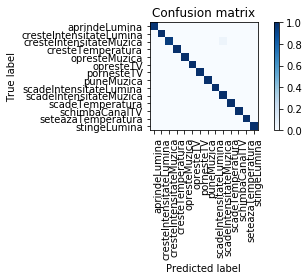

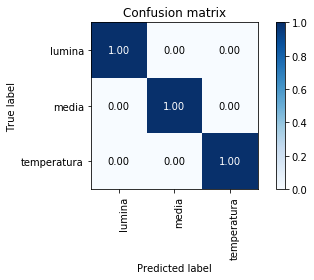

Intent F1: 0.994643
Slot F1: 0.994652
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 1-rerouting
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.081081
F score 0.081081
Slot filling
F1 score: 0.043906
Accuracy: 0.165058
------------------epoch :  0  Loss:  17.638184 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.635135
F score 0.635135
Slot filling
F1 score: 0.454874
Accuracy: 0.916409
Current F score mean 0.5450043906722607
Best F score mean 0.5450043906722607
------------------epoch :  1  Loss:  1.1465362 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.891892


           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997297
F score 0.997297
Slot filling
F1 score: 0.977178
Accuracy: 0.997876
Current F score mean 0.9872378602669059
Best F score mean 0.9994913530010172
------------------epoch :  5  Loss:  0.006133445 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997297
F score 0.997297
Slot filling
F1 score: 0.989583
Accuracy: 0.998649
Current F score mean 0.9934403153153153
Best F score mean 0.9994913530010172
------------------epoch :  6  Loss:  0.004370434 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997297
F score 0.997297
Slot filling
F1 score: 0.989583
Accuracy: 0.998649
Current F score mean 0.9934403153153153
Best F score mean 0.9994913530010172
------------------epoch :  7  Loss:  0.0034659912 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.994840
Accuracy: 0.999224
Current F score mean 0.9974200206398349
Best F score mean 0.9994913530010172
------------------epoch :  11  Loss:  0.0028137807 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.994840
Accuracy: 0.999224
Current F score mean 0.9974200206398349
Best F score mean 0.9994913530010172
------------------epoch :  12  Loss:  0.0026337607 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.994840
Accuracy: 0.999224
Current F score mean 0.9974200206398349
Best F score mean 0.9994913530010172
------------------epoch :  13  Loss:  0.0024878385 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 

<Figure size 432x288 with 0 Axes>

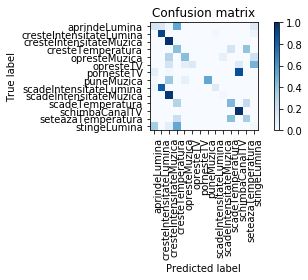

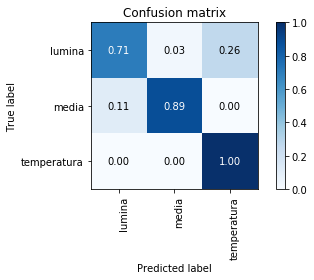

Intent F1: 0.398214
Slot F1: 0.734780
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 2-rerouting
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.030211
F score 0.030211
Slot filling
F1 score: 0.003602
Accuracy: 0.083729
------------------epoch :  0  Loss:  19.229395 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.640483
F score 0.640483
Slot filling
F1 score: 0.440860
Accuracy: 0.922961
Current F score mean 0.540671799369782
Best F score mean 0.540671799369782
------------------epoch :  1  Loss:  3.2872057 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.930514
F 

------------------epoch :  5  Loss:  0.027392711 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.987915
F score 0.987915
Slot filling
F1 score: 0.997792
Accuracy: 0.999353
Current F score mean 0.9928539511681105
Best F score mean 0.9928539511681105
------------------epoch :  6  Loss:  0.021836545 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.997792
Accuracy: 0.999353
Current F score mean 0.9988962472406181
Best F score mean 0.9988962472406181
------------------epoch :  7  Loss:  0.037819613 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.996979
F score 0.996979
Slot filling
F1 score: 0.997792
Accuracy: 0.999353
Current F score mean 0.9973856732224913
Best F score mean 0.9988962472406181
------------------epoch :  8  Loss:  0.013099432 ----------------------
           VA

------------------epoch :  12  Loss:  0.009181642 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  13  Loss:  0.009045338 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  14  Loss:  0.008945509 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  15  Loss:  0.008859577 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.0

<Figure size 432x288 with 0 Axes>

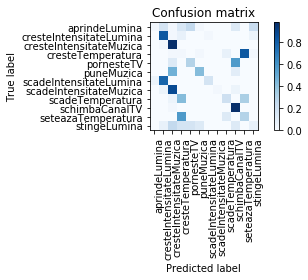

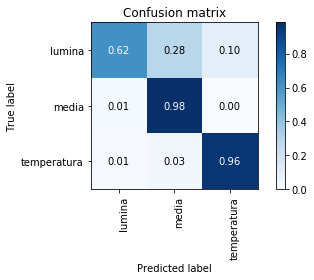

Intent F1: 0.360417
Slot F1: 0.546419
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 31-rerouting
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.118959
F score 0.118959
Slot filling
F1 score: 0.011570
Accuracy: 0.060276
------------------epoch :  0  Loss:  24.871687 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.680297
F score 0.680297
Slot filling
F1 score: 0.260105
Accuracy: 0.901221
Current F score mean 0.470201422962087
Best F score mean 0.470201422962087
------------------epoch :  1  Loss:  8.181333 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.918216
F 

Current F score mean 0.9898366358582585
Best F score mean 0.9898366358582585
------------------epoch :  5  Loss:  0.13767461 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.985130
F score 0.985130
Slot filling
F1 score: 0.990826
Accuracy: 0.998407
Current F score mean 0.9879778997987789
Best F score mean 0.9898366358582585
------------------epoch :  6  Loss:  0.022046454 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.985130
F score 0.985130
Slot filling
F1 score: 0.990826
Accuracy: 0.998407
Current F score mean 0.9879778997987789
Best F score mean 0.9898366358582585
------------------epoch :  7  Loss:  0.018701652 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.985130
F score 0.985130
Slot filling
F1 score: 0.990826
Accuracy: 0.998407
Current F score mean 0.9879778997987789
Best F score mean 0.9898366358582585
---------

------------------epoch :  11  Loss:  0.014616665 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992509
F score 0.992509
Slot filling
F1 score: 0.973134
Accuracy: 0.995720
Current F score mean 0.9828218458270446
Best F score mean 0.9928641829292332
------------------epoch :  12  Loss:  0.01376703 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992509
F score 0.992509
Slot filling
F1 score: 0.973134
Accuracy: 0.995720
Current F score mean 0.9828218458270446
Best F score mean 0.9928641829292332
------------------epoch :  13  Loss:  0.013147939 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992509
F score 0.992509
Slot filling
F1 score: 0.973134
Accuracy: 0.995720
Current F score mean 0.9828218458270446
Best F score mean 0.9928641829292332
------------------epoch :  14  Loss:  0.012675001 ----------------------
          

<Figure size 432x288 with 0 Axes>

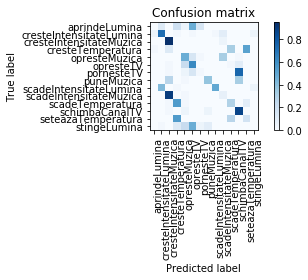

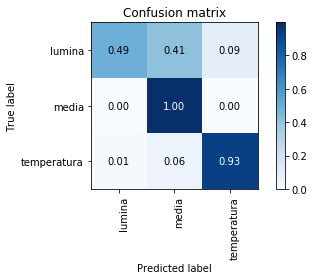

Intent F1: 0.364286
Slot F1: 0.480737
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 32-rerouting
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.111111
F score 0.111111
Slot filling
F1 score: 0.030620
Accuracy: 0.073810
------------------epoch :  0  Loss:  18.633043 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.474074
F score 0.474074
Slot filling
F1 score: 0.530271
Accuracy: 0.941799
Current F score mean 0.5021727364107322
Best F score mean 0.5021727364107322
------------------epoch :  1  Loss:  6.454138 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.807407


------------------epoch :  5  Loss:  0.1477519 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.988889
F score 0.988889
Slot filling
F1 score: 0.947712
Accuracy: 0.993915
Current F score mean 0.9683006535947712
Best F score mean 0.9801672640382317
------------------epoch :  6  Loss:  0.026740868 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.968699
Accuracy: 0.996032
Current F score mean 0.9843492586490938
Best F score mean 0.9843492586490938
------------------epoch :  7  Loss:  0.025746403 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.967105
Accuracy: 0.996032
Current F score mean 0.9835526315789473
Best F score mean 0.9843492586490938
------------------epoch :  8  Loss:  0.019249506 ----------------------
           VALI

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.985075
F score 0.985075
Slot filling
F1 score: 0.981513
Accuracy: 0.997068
Current F score mean 0.9832936159538441
Best F score mean 0.9884488448844885
------------------epoch :  12  Loss:  0.013953912 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.985075
F score 0.985075
Slot filling
F1 score: 0.981513
Accuracy: 0.997068
Current F score mean 0.9832936159538441
Best F score mean 0.9884488448844885
------------------epoch :  13  Loss:  0.013447065 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.985075
F score 0.985075
Slot filling
F1 score: 0.981513
Accuracy: 0.997068
Current F score mean 0.9832936159538441
Best F score mean 0.9884488448844885
------------------epoch :  14  Loss:  0.013050247 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.9

<Figure size 432x288 with 0 Axes>

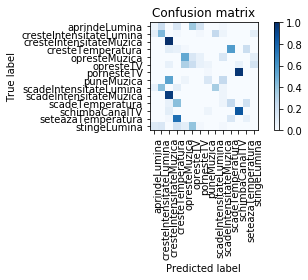

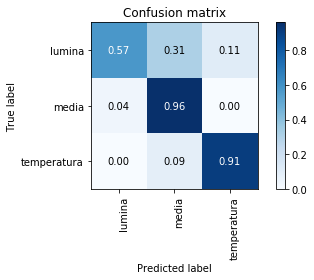

Intent F1: 0.289286
Slot F1: 0.452796
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 33-rerouting
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.005051
F score 0.005051
Slot filling
F1 score: 0.012220
Accuracy: 0.200216
------------------epoch :  0  Loss:  22.363869 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.530303
F score 0.530303
Slot filling
F1 score: 0.349624
Accuracy: 0.877706
Current F score mean 0.4399635452267031
Best F score mean 0.4399635452267031
------------------epoch :  1  Loss:  8.567474 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.843434


------------------epoch :  5  Loss:  0.113383 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.949495
F score 0.949495
Slot filling
F1 score: 0.971429
Accuracy: 0.995671
Current F score mean 0.9604617604617605
Best F score mean 0.9778456203829338
------------------epoch :  6  Loss:  0.28772232 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.969697
F score 0.969697
Slot filling
F1 score: 0.978852
Accuracy: 0.996392
Current F score mean 0.9742744667215967
Best F score mean 0.9778456203829338
------------------epoch :  7  Loss:  1.221424 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.974747
F score 0.974747
Slot filling
F1 score: 0.975904
Accuracy: 0.996392
Current F score mean 0.975325544602653
Best F score mean 0.9778456203829338
------------------epoch :  8  Loss:  0.026604004 ----------------------
           VALIDATION

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.979798
F score 0.979798
Slot filling
F1 score: 0.977307
Accuracy: 0.996032
Current F score mean 0.9785525451183545
Best F score mean 0.984871372333608
------------------epoch :  12  Loss:  0.07595582 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.989899
F score 0.989899
Slot filling
F1 score: 0.974281
Accuracy: 0.995671
Current F score mean 0.9820901908647748
Best F score mean 0.984871372333608
------------------epoch :  13  Loss:  0.014897304 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.989899
F score 0.989899
Slot filling
F1 score: 0.977307
Accuracy: 0.996032
Current F score mean 0.9836030501688595
Best F score mean 0.984871372333608
------------------epoch :  14  Loss:  0.012085281 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.99494

<Figure size 432x288 with 0 Axes>

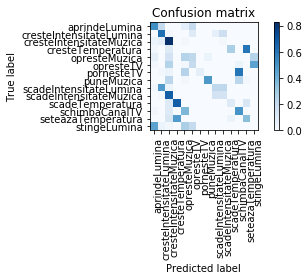

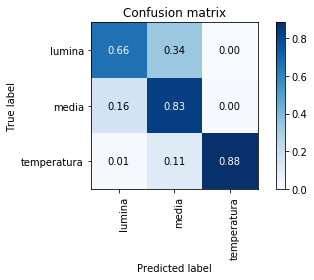

Intent F1: 0.307692
Slot F1: 0.441921


<Figure size 432x288 with 0 Axes>

In [7]:
import train
import test

results = dict()
for i in range(len(training_data_paths)):
    
    # Load data
    data = data_loader.read_datasets(w2v, training_data_paths[i], test_data_paths[i], test=True)
    
    FLAGS = set_flags(data, scenario=scenario_nums[i])
    
    # Train model
    print('TRAINING ' + scenario_nums[i])
    train.train(model_s2i.CapsNetS2I, data, FLAGS, batches_rand=False)
    
    # Test model
    print('TESTING ' + scenario_nums[i])
    intent_f, slot_f = test.test(model_s2i.CapsNetS2I, data, FLAGS)
    results[scenario_nums[i]] = dict()
    results[scenario_nums[i]]['intent_f1'] = intent_f
    results[scenario_nums[i]]['slot_f1'] = slot_f
        
    # Reset flags
    del_all_flags(FLAGS)

write_csv(results)